# Regression Analysis of World Happiness Data

### Main Objectives

- What are the factors that are highly/lowly correlated with happiness score?
- What common visualizations are used in machine learning projects and how can we leverage most out of it?
- Can we fit a straight-line model to predict a nation's happiness score?

---

## Variable Nomenclature

- Country (Name of the country surveyed)
- Year (Designated year of data)
- Life Ladder (Happiness Score on a scale of 0-10)
- Log GDP (a measure of a country's economic output per person, adjusted for purchasing power parity)
- Social Support (a measure of the presence or absence of social networks and support structures)
- Life Expectancy (a measure of the expected number of years of life in good health)
- Freedom (a measure of the degree of autonomy individuals have in making important life decisions)
- Generosity (a measure of the level of generosity and charitable giving in a country)
- Perception of Corruption (a measure of the extent to which corruption is perceived to exist within a country)
- Positive Affect (a measure of the frequency and intensity of positive emotions experienced by individuals)
- Negative Affect (a measure of the frequency and intensity of negative emotions experienced by individuals)
- Continent (Continent in which the country is associated with))

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from intro_Data import *
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#import the data
data = pd.read_csv('./world_happiness_final.csv')
data = data.drop('Unnamed: 0',axis=1) #drop repeated index
data = data.rename(columns={'continent':'Continent'})
data.head()

,country,year,life ladder,log gdp,social support,life expectancy,freedom,generosity,corruption perception,positive affect,negative affect,government trust,Continent
0,Lebanon,2005,5.491245,9.565487,0.796278,65.099998,0.703206,NaN,0.945177,0.558135,0.292150,NaN,Asia
1,Hungary,2005,5.193933,10.103150,0.929628,65.000000,0.696874,NaN,0.902811,0.578233,0.290327,0.360526,Europe
2,Italy,2005,6.853784,10.697855,0.928001,70.599998,0.802195,NaN,0.943912,0.606102,0.294698,0.238738,Europe
3,Mexico,2005,6.580658,9.786312,0.902808,64.400002,0.813745,NaN,0.764249,0.763287,0.218943,0.426359,North America
4,Poland,2005,5.587209,9.848898,0.921528,66.199997,0.782473,NaN,0.982931,0.610626,0.282439,0.068769,Europe


---

## Pre-modeling Visualizations

Which variables are mostly correlated with life ladder (target)?

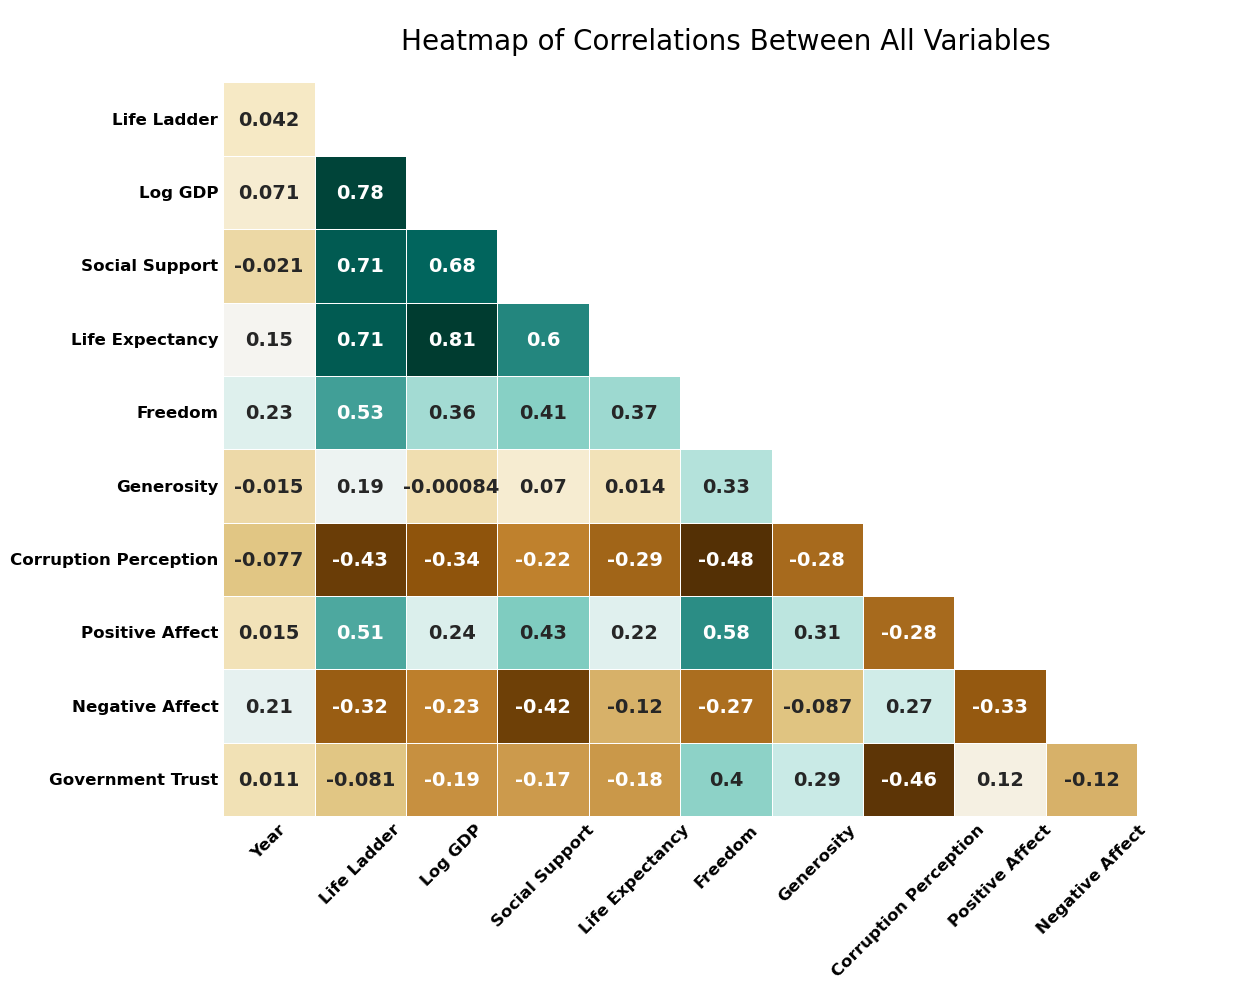

In [3]:
plt.figure(figsize = [15,10])

row_labels = ['Life Ladder', 'Log GDP', 'Social Support', 'Life Expectancy', 'Freedom', 'Generosity',
             'Corruption Perception','Positive Affect','Negative Affect','Government Trust']
col_labels = ['Year','Life Ladder','Log GDP','Social Support','Life Expectancy','Freedom','Generosity',
             'Corruption Perception','Positive Affect', 'Negative Affect']

c = data.corr()
mask = np.triu(c)
sns.heatmap(c, cmap='BrBG',mask = mask, annot = True, annot_kws = {'fontsize':14, 'weight':'bold'},
           linewidths = 0.5)
ax = plt.gca()
ax.set_yticks(ax.get_yticks()[1:], labels = row_labels[0:], size = 12, weight = 'bold')
ax.set_xticks(ax.get_xticks()[:-1], labels = col_labels[0:], size = 12, weight = 'bold',rotation=45)
ax.tick_params(length = 0)
cbar = ax.collections[0].colorbar
cbar.ax.set_visible(False)
plt.tight_layout()

plt.title('Heatmap of Correlations Between All Variables',size=20,y=0.94)
plt.savefig('heatmap.png',bbox_inces='tight')
plt.show()

The heatmap suggests that life ladder (target) has strong linear relationship with log gdp, social support,  and life expectancy. It also has moderate relationship with freedom, corruption perception, positive affect and negative affect. Little to no linear relationship is found with generosity and government trust.

---

Does low correlation mean no relationship? Let's figure out if there's non-linear relationship between low correlated variables.

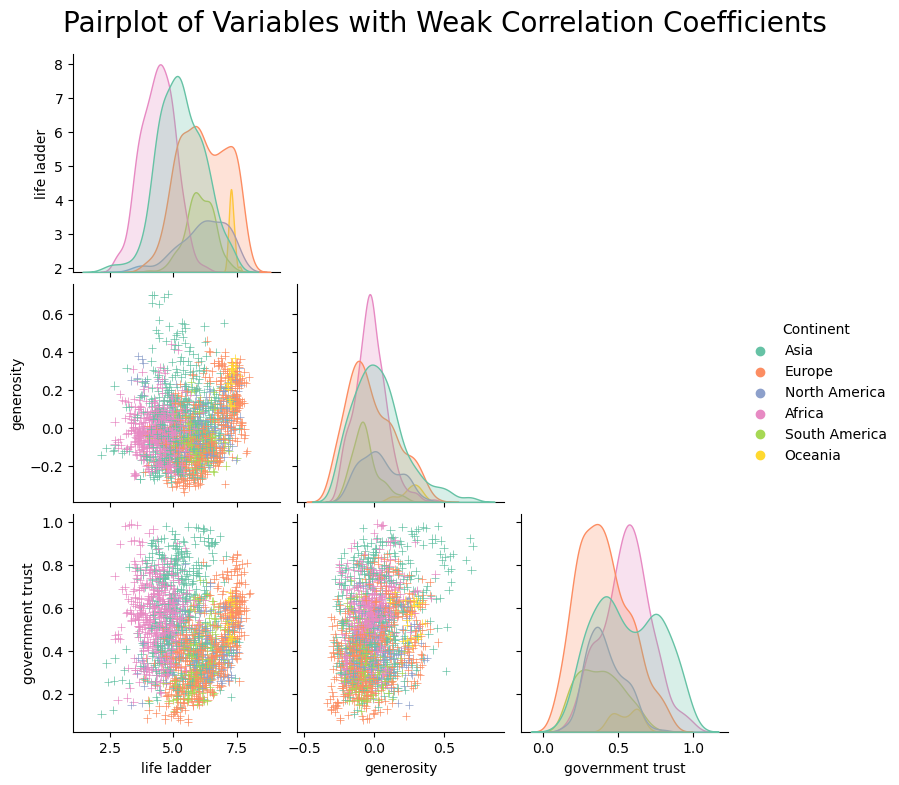

In [4]:
low_cor = ['life ladder','generosity','government trust','Continent']
ax = sns.pairplot(data[low_cor],hue='Continent',palette = 'Set2',plot_kws=dict(marker="+", linewidth=0.5))
ax.axes[0,1].set_visible(False)
ax.axes[0,2].set_visible(False)
ax.axes[1,2].set_visible(False)
ax.fig.suptitle('Pairplot of Variables with Weak Correlation Coefficients',size=20,y=1.04)
ax.legend.set_title('Continent')
plt.show()

It appears that there exists no meaningful relationship between life ladder (target) and the low correlated variables (government trust and generosity). Even comparing different continents did not give meaningful results. We may consider to leave these variables out when making predictions.

---

One of the important assumptions of linear regression is that our target variable must be approximately normal. A histogram and boxplot will reveal the shape of distribution.

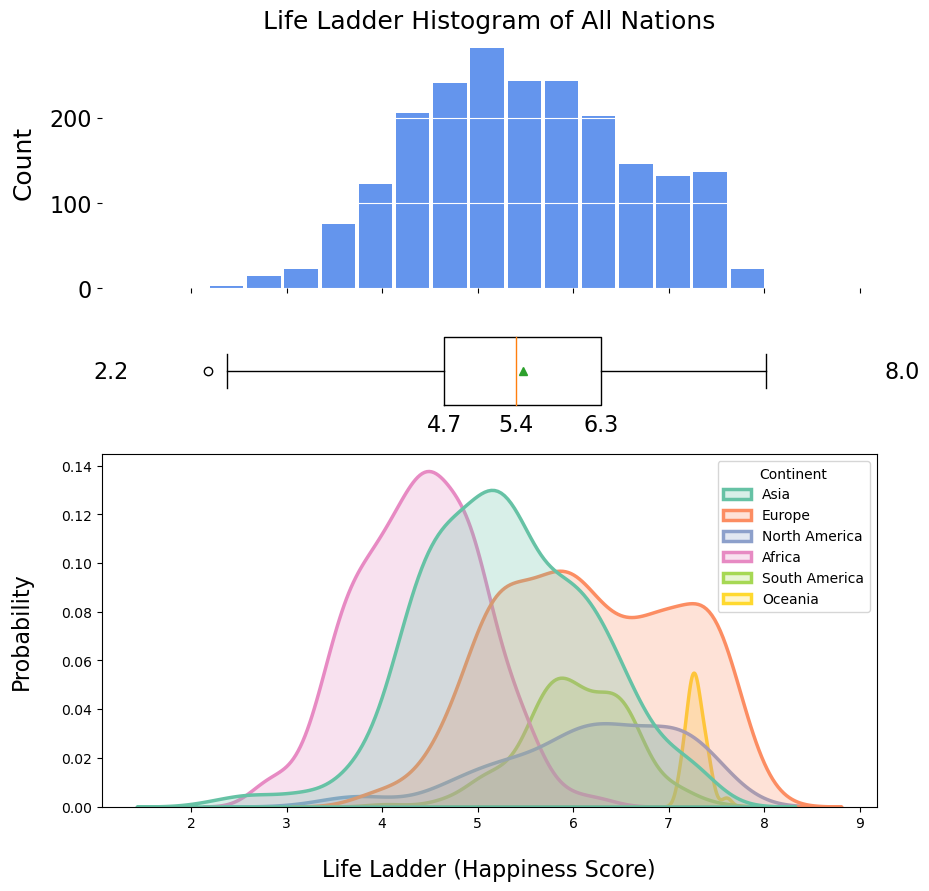

In [15]:
life_ladder = data['life ladder']
life_ladder_kde = data[['life ladder','Continent']]

f,[ax_hist,ax_box,ax_kde] = plt.subplots(3, 1, figsize = (10,10), gridspec_kw={'height_ratios':[0.5,0.15,0.7]}, sharex=True)

#constants and params
LABEL_SIZE = 18
TICK_SIZE = 16
n_bins = 15

#histogram
ax_hist.hist(life_ladder, rwidth = 0.9, bins = n_bins, color = 'cornflowerblue', fill = True) #ax = does not work
ax_hist.tick_params(labelsize=TICK_SIZE)
ax_hist.set_ylabel('Count', fontsize = LABEL_SIZE, labelpad = 10)
ax_hist.grid(axis = 'y', color = 'white')
[ax_hist.spines[i].set_visible(False) for i in ax_hist.spines]
ax_hist.set_title('Life Ladder Histogram of All Nations', fontsize = LABEL_SIZE)

#box plot
ax_box.boxplot(life_ladder, vert = False, widths = 0.9, showmeans=True)
[ax_box.spines[i].set_visible(False) for i in ax_box.spines]
m,q1,q2,q3,x = np.quantile(life_ladder,q=[0,0.25,0.5,0.75,1])

for item in q1,q2,q3:
    ax_box.text(item,0.2,f'{item:.1f}',fontsize = TICK_SIZE, ha = 'center')

ax_box.text(-0.01,0.5,f'{m:.1f}',transform = ax_box.transAxes, fontsize = TICK_SIZE, va = 'center')
ax_box.text(1.01,0.5,f'{x:.1f}',transform = ax_box.transAxes, fontsize = TICK_SIZE, va = 'center')
ax_box.set_yticks([])
ax_box.xaxis.tick_top()
ax_box.tick_params(axis='x',size=0,labelsize=TICK_SIZE)
ax_box.set_xlabel('Life Ladder (Happiness Score)', fontsize = LABEL_SIZE, labelpad = 40,
                 style = 'italic')
ax_box.tick_params(axis = 'x', size = 0, labelsize = TICK_SIZE)

#add quantile text
m,q1,q2,q3,x = np.quantile(life_ladder,q=[0,0.25,0.5,0.75,1])

#kde plot
ax_kde = sns.kdeplot(data = life_ladder_kde,x='life ladder', hue='Continent', palette = 'Set2',linewidth = 2.5, shade= True)

ax_kde.set_xlabel('Life Ladder (Happiness Score)', fontsize = 16, labelpad = 20)
ax_kde.set_ylabel('Probability', fontsize = 16, labelpad = 20)

plt.show()

Interestingly, the happiness scores are approximately normally distributed (even for separate continents!). We are good to proceed with fitting the data.

---
## Fitting the Model Using Ridge Regression

For this project, we will fit a regularized linear regression model (Ridge) and compare the two performances.

- Drop geneosity and government trust (lack of linear relationship)
- Drop country (we will use continent as categorical variable instead)
- Drop year (year won't be too important for prediction)

In [6]:
X_y = data.drop(['government trust','generosity','country','year'],axis=1)
X_y = X_y.dropna()
X = X_y.drop('life ladder',axis=1)
y = X_y['life ladder']

Create dummy variables for continent 

In [7]:
continent = pd.get_dummies(X['Continent'], drop_first=True)
X = X.drop('Continent',axis=1)
X = pd.concat([X,continent],axis=1).values
y = y.values

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [9]:
alpha_range = np.linspace(0,1,20)

In [10]:
a_range = np.linspace(0,15,100)
k = 10
ss = StandardScaler()

avg_tr_score=[]
avg_te_score=[]

for a in a_range:
    rid_reg = Ridge(alpha = a)
    train_scores, test_scores = do_Kfold(rid_reg,X,y,k,ss)
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))

In [11]:
idx_max = np.argmax(avg_te_score)
    
print('Optimal alpha in the range tested: ', a_range[idx_max])
print('Avg. training score at this value: ', avg_tr_score[idx_max])
print('Avg. testing score at this value: ', avg_te_score[idx_max])

Optimal alpha in the range tested:  5.757575757575758
Avg. training score at this value:  0.7890171879525553
Avg. testing score at this value:  0.7852343609569583


### Caveat: Do not be deceived by the y-axis, the alpha value is not dramatically changing our scores.

### By deafult, matplotlib would set the y-axis to what they think is the best. However, it is important to not (even by mistake) have any deceiving elements in visaulizations such as distorted y-axis. 

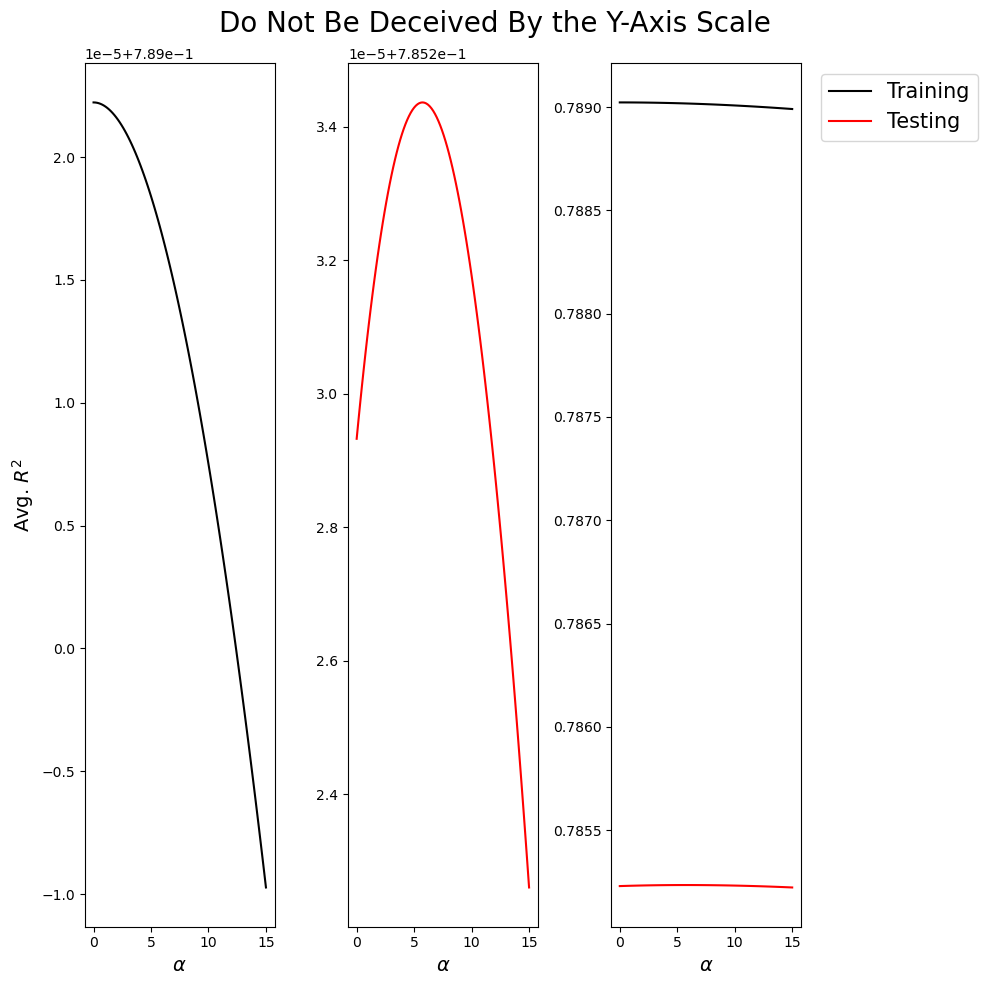

In [14]:
f,[ax_train,ax_test,ax_both] = plt.subplots(1, 3, figsize = (10,10), sharex=True)

ax_train.plot(a_range, avg_tr_score, color='k', label='Training')
ax_train.set_xlabel('$\\alpha$', fontsize=14)
ax_train.set_ylabel('Avg. $R^2$', fontsize=14)
ax_test.plot(a_range, avg_te_score, color='r', label='Testing')
ax_test.set_xlabel('$\\alpha$', fontsize=14)

ax_both.plot(a_range, avg_tr_score, color='k', label='Training')
ax_both.plot(a_range, avg_te_score, color='r', label='Testing')
ax_both.set_xlabel('$\\alpha$', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1),fontsize=15)

f.suptitle('Do Not Be Deceived By the Y-Axis Scale',size=20)

plt.tight_layout()
plt.show()

Let's make a model with optimal alpha value.

In [ ]:
optimal_alpha = a_range[idx_max]
ss = StandardScaler()

ridge = Ridge(alpha = optimal_alpha)
train, test = do_Kfold(ridge,X,y,k=10,scaler=ss)

In [ ]:
print('Avg. training score: ', np.mean(train))
print('Avg. testing score: ', np.mean(test))

## Least-Squares Regression Line Equation

$$\hat{y}=0.40133949x_1+0.17433538x_2+0.14768882x_3+0.08611276x_4-0.14729462x_5+0.18666922x_6-0.02682801x_7+0.06407464x_8+0.17143659x_9+0.17525709x_{10}+0.07689052x_{11}+0.13081436x_{12}$$

Where $x_1$ = log gdp, $x_2$ = social support, $x_3$ = life expectancy, $x_4$ = freedom, $x_5$ = corruption perception, $x_6$ = positive affect, $x_7$ = negative affect, $x_8$ - $x_{12}$ = continent (categorical dummy variables)

---

# Conclusion

The primary purpose of this notebook is to showcase visualizations commonly used for machine learning projects. Oftentimes, the importance of visualizations is not weighted equally as the modeling portion of the project. However, visualizations can reveal mistakes or find meaning insights. This project's primary focus is not rigorous linear regression analysis; hence, numerous steps of complete regression analysis is omitted.

We were able to see that log gdp, social support,  and life expectancy had strong linear relationship with happiness score. This intuitively makes sense because more money, support from society and high average life expectancy would certainly have positive effect on the happiness score. We were also able to see weak correlated variables with happiness score, and through visualizations, identify that no particular relationship existed between them. 

We then proceeded on to creating a ridge regression model, and performed cross-validation among various alpha values to find the optimal model. We were able to discuss the limitations of default matplotlib graphs as it provided us with a deceiving y-axis limits. Hence it is always important to check our visualizations to make sure that no information is misleading (even by mistake). 

Finally, we were able to output a linear regression line by examining the estimated $\beta$ coefficients. 

---